In [1]:
# Daniel Bandala Alvarez @ feb 2022
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import fmin_tnc
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn import metrics

## Read data

In [2]:
data = pd.read_csv("weight-height.csv")
n = len(data)

In [3]:
data.head()

,Gender,Height,Weight
0,Male,73.847017,241.893563
1,Male,68.781904,162.310473
2,Male,74.110105,212.740856
3,Male,71.730978,220.042470
4,Male,69.881796,206.349801


In [4]:
# select data
feature_cols = ['Height', 'Weight']
X = data[feature_cols] # Features
y = data.Gender.map({'Male': 0,'Female': 1})

In [5]:
# convert to metric system
X.Height = X.Height*0.0254
X.Weight = X.Weight*0.453592

/tmp/ipykernel_85739/1513025680.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.Height = X.Height*0.0254
/tmp/ipykernel_85739/1513025680.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.Weight = X.Weight*0.453592


In [6]:
X.head()

,Height,Weight
0,1.875714,109.720985
1,1.747060,73.622732
2,1.882397,96.497550
3,1.821967,99.809504
4,1.774998,93.598619


## Visualize data

In [7]:
X.describe()

,Height,Weight
count,10000.000000,10000.000000
mean,1.685736,73.228054
std,0.097727,14.564131
min,1.378284,29.347460
25%,1.613043,61.605982
50%,1.684479,73.124894
75%,1.757026,84.898599
max,2.006568,122.465167


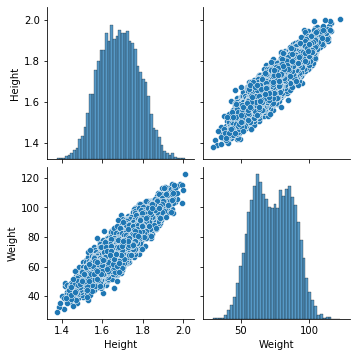

In [8]:
sns.pairplot(X)

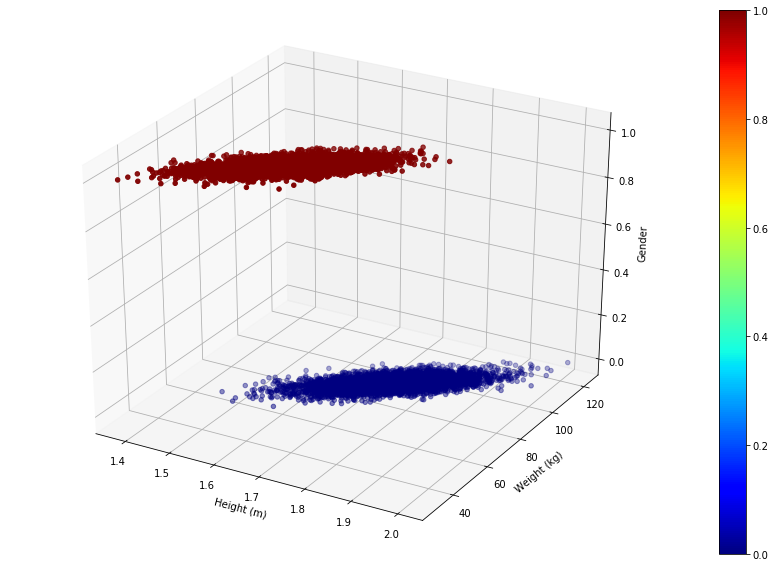

In [9]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')
img = ax.scatter(X.Height,X.Weight,y,c=y,cmap="jet")
fig.colorbar(img)
ax.set_xlabel(feature_cols[0]+" (m)")
ax.set_ylabel(feature_cols[1]+" (kg)")
ax.set_zlabel("Gender")
plt.show()

## Split the dataset

In [10]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=1)

In [11]:
len(X_train)

7500

In [12]:
len(X_test)

2500

## Perform logistic regression
3 ways to fit model:
* SKLearn library
* fmi_tnc optimizer
* Iterating with gradient descent

In [13]:
# sklearn model
log_reg = LogisticRegression()
log_reg.fit(X_train,y_train)

LogisticRegression()

In [14]:
# Activation function used to map any real value between 0 and 1
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
# Computes the weighted sum of inputs
def net_input(theta, x):
    return np.dot(x, theta)
# Returns the probability after passing through sigmoid
def probability(theta, x):
    return sigmoid(net_input(theta, x))

In [15]:
# Computes the cost function for all the training samples
def cost_function(theta, x, y):
    m = x.shape[0]
    total_cost = -(1 / m) * np.sum(
        y * np.log(probability(theta, x)) + (1 - y) * np.log(
            1 - probability(theta, x)))
    return total_cost
# Computes the gradient of the cost function at the point theta
def gradient(theta, x, y):
    m = x.shape[0]
    return (1 / m) * np.dot(x.T, probability(theta, x) - y)

In [16]:
# fit model using fmin_tnc optimizer function
def fit(x, y, theta, eta=0.5):
    opt_weights = fmin_tnc(func=cost_function, x0=theta,
                  fprime=gradient,args=(x, y.flatten()))
    return opt_weights[0]

In [17]:
# fit model with iterations
def manual_fit(x, y, theta, eta=0.0015, max_cost=0.1, iters=100000):
    theta_ant = theta.copy()
    for i in range(iters):
        grad = gradient(theta,X_aux,y_aux)
        theta = theta_ant-eta*grad
        total_cost = cost_function(theta,X_aux,y_aux)
        if total_cost<=max_cost:
            break
        theta_ant = theta.copy()
    return theta.T[0],total_cost

In [19]:
# predict function
def predict(x,parameters):
    theta = parameters[:, np.newaxis]
    return np.round(probability(theta, x))
# accuracy function
def accuracy(x, actual_classes, parameters, probab_threshold=0.5):
    predicted_classes = (predict(x,parameters) >= 
                         probab_threshold).astype(int)
    predicted_classes = predicted_classes.flatten()
    accuracy = np.mean(predicted_classes == actual_classes)
    return accuracy * 100

In [20]:
# initialize variables
X_aux = X_train.to_numpy()
y_aux = y_train.to_numpy()[:, np.newaxis]
theta = np.zeros((X_train.shape[1], 1))
# fit model with gradient descent
theta_opt,total_cost = manual_fit(X_aux,y_aux,theta,iters=400000)
total_cost

0.22600928750229038

In [21]:
print(theta_opt)
print("\nAccuracy:")
accuracy(X_test.to_numpy(),y_test.to_numpy(),parameters=theta_opt)

[12.4954597  -0.28831064]

Accuracy:


91.47999999999999

In [24]:
# fit model - logistic regression
theta = np.zeros((X_train.shape[1], 1))
parameters_opt = fit(X_aux, y_aux, theta)

  NIT   NF   F                       GTG
    0    1  6.931471805599453E-01   3.09257250E+01
    1    3  6.820100758967929E-01   1.12263400E-02
tnc: stepmx = 1000
    2    6  2.518283216271781E-01   2.80228764E+00
    3    8  2.490138586787933E-01   4.74782155E-02
    4   10  2.429913514096622E-01   3.85760418E+00
    5   15  2.087336629391401E-01   2.46863326E-02
    6   17  2.080125268017469E-01   4.98168912E-02
    7   19  2.079376388292084E-01   3.40945004E-06
tnc: fscale = 541.574
tnc: |fn-fn-1] = 5.04754e-09 -> convergence
    8   21  2.079376337816641E-01   3.98726198E-10
tnc: Converged (|f_n-f_(n-1)| ~= 0)


In [25]:
print(parameters_opt)
print("\nAccuracy:")
accuracy(X_test.to_numpy(),y_test.to_numpy(),parameters=parameters_opt)

[18.90356163 -0.43513849]

Accuracy:


91.36

## Make prediction using the model

In [26]:
y_pred=log_reg.predict(X_test)

In [27]:
y_pred

array([1, 0, 0, ..., 0, 1, 1])

## Confusion matrix

In [28]:
cnf_matrix = metrics.confusion_matrix(y_test,y_pred)

In [29]:
cnf_matrix

array([[1155,  116],
       [ 105, 1124]])

Text(0.5, 257.44, 'Gender')

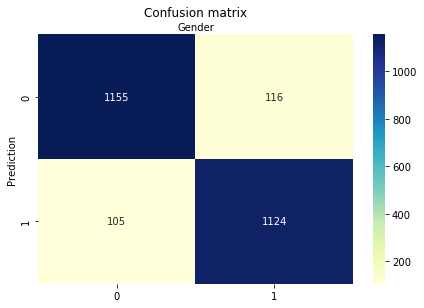

In [30]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Prediction')
plt.xlabel('Gender')

## Performance metrics

In [31]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred)*100)
print("Precision:",metrics.precision_score(y_test, y_pred)*100)
print("Recall:",metrics.recall_score(y_test, y_pred)*100)

Accuracy: 91.16
Precision: 90.64516129032259
Recall: 91.45646867371848


In [32]:
# paremters from confusion matrix
tp = cnf_matrix[1,1]
tn = cnf_matrix[0,0]
fp = cnf_matrix[0,1]
fn = cnf_matrix[1,0]

In [37]:
# error
err = (fp+fn)/(fp+fn+tp+tn)
print("Error: ",err)

Error:  0.0884


In [39]:
# accuracy
acc = (tp+tn)/(fp+fn+tp+tn)
print("Accuracy: ",acc)

Accuracy:  0.9116


In [41]:
# sensibilidad
tpr = tp/(tp+fn)
print("Recall (true positive rate): ",tpr)

Recall (true positive rate):  0.9145646867371847


In [42]:
# false positive rate
fpr = fp/(fp+tn)
print("False positive rate: ",fpr)

False positive rate:  0.09126671911880409


In [43]:
# precision
pre = tp/(tp+fp)
print("Precision: ",pre)

Precision:  0.9064516129032258


In [44]:
# f1-score
f1 = 2*pre*tpr/(pre+tpr)
print("F1-Score: ",f1)

F1-Score:  0.9104900769542326


## Decision plane

In [45]:
log_reg.coef_[0]

array([ 7.4764138 , -0.35073516])

In [46]:
coefs = log_reg.coef_[0]
intercept = log_reg.intercept_

In [47]:
x1s = np.outer(np.linspace(1.4, 1.8, 20), np.ones(20))
x2s = np.outer(np.linspace(60, 90, 20), np.ones(20)).T
x3s = coefs[0]*x1s + coefs[1]*x2s + intercept

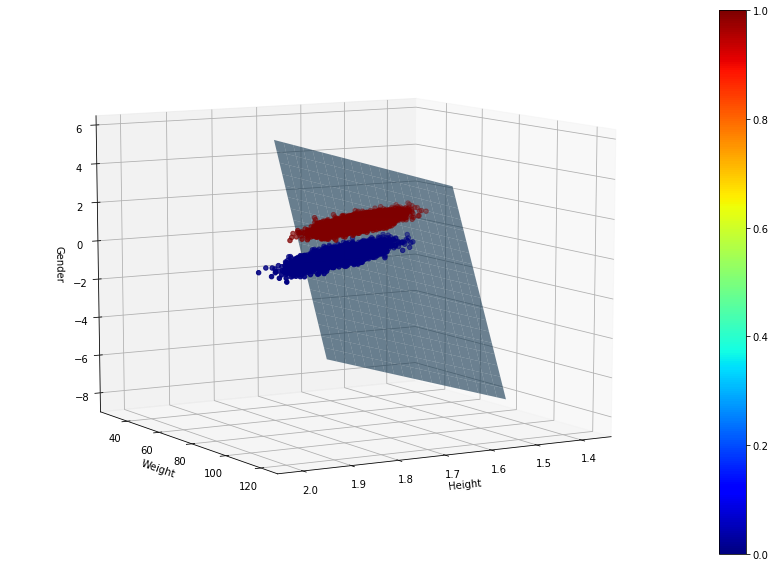

In [48]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')
img = ax.scatter(X.Height,X.Weight,y,c=y,cmap="jet")
ax.plot_surface(x1s,x2s,x3s,alpha=0.6)
fig.colorbar(img)
ax.set_xlabel(feature_cols[0])
ax.set_ylabel(feature_cols[1])
ax.set_zlabel("Gender")
ax.view_init(10, 60)
plt.show()

## ROC curve
Receiver Operating Characteristic(ROC) curve is a plot of the true positive rate against the false positive rate. It shows the tradeoff between sensitivity and specificity

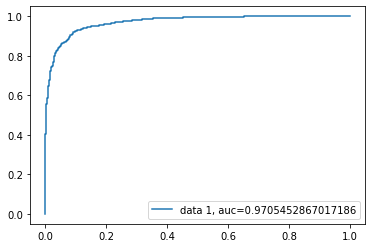

In [49]:
y_pred_proba = log_reg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

## Training curve

In [50]:
train_sizes,train_scores,test_scores = learning_curve(LogisticRegression(),X,y,cv=10,scoring='accuracy',n_jobs=1,train_sizes=np.linspace(0.01,1,60))

In [51]:
# statistic results
train_mean = np.mean(train_scores,axis=1)
train_std = np.std(train_scores,axis=1)
test_mean = np.mean(test_scores,axis=1)
test_std = np.std(test_scores,axis=1)

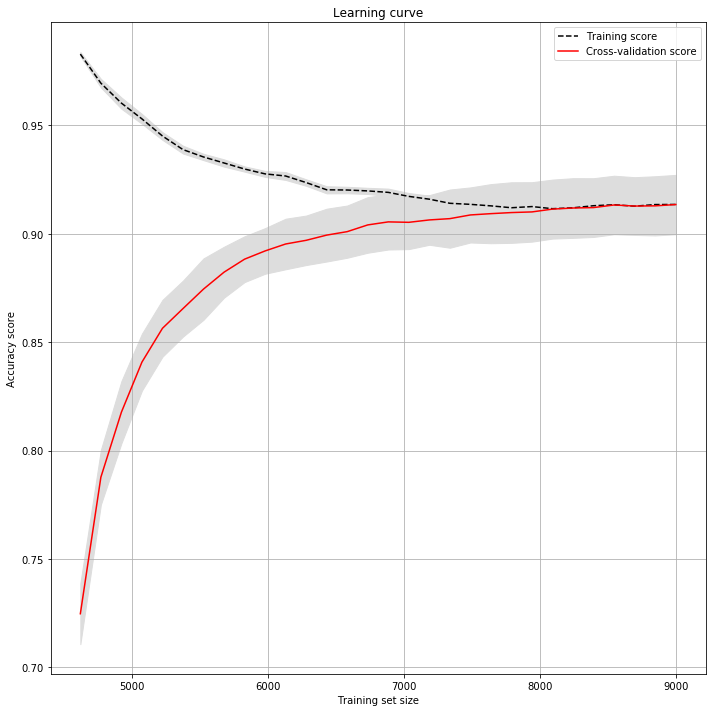

In [52]:
plt.subplots(1,figsize=(10,10))
# draw lines
plt.plot(train_sizes,train_mean,"--",color="black",label="Training score")
plt.plot(train_sizes,test_mean,color="red",label="Cross-validation score")
# draw bands
plt.fill_between(train_sizes,train_mean-train_std,train_mean+train_std,color="#DDDDDD")
plt.fill_between(train_sizes,test_mean-test_std,test_mean+test_std,color="#DDDDDD")
# create plot
plt.title("Learning curve")
plt.xlabel("Training set size")
plt.ylabel("Accuracy score")
plt.legend(loc="best")
plt.tight_layout()
plt.grid()